In [1]:
from __future__ import print_function
from rdkit.Chem.Draw import IPythonConsole, ReactionToImage, MolToImage
import pandas as pd
import numpy as np
import json
import sys
sys.path.append('../../')
from retrosim.utils.draw import ReactionStringToImage, TransformStringToImage
from retrosim.utils.generate_retro_templates import process_an_example
from retrosim.data.get_data import get_data_df, split_data_df

# label the 50,000 reactions as train/test/val in the ratio of 80%/10%/10% within each class

In [2]:
data = get_data_df('../data/data_processed.csv')
split_data_df(data) # 80/10/10 within each class

15151 rows with class value 1
11896 rows with class value 2
5662 rows with class value 3
909 rows with class value 4
672 rows with class value 5
8237 rows with class value 6
4614 rows with class value 7
811 rows with class value 8
1834 rows with class value 9
230 rows with class value 10
train    40008
test      5007
val       5001
Name: dataset, dtype: int64


Br[c:1]1[n:2]([CH3:3])[cH:4][n:5][c:6]1-[c:7]1[cH:8][c:9]([C:10]#[N:11])[cH:12][cH:13][n:14]1.OB(O)[c:15]1[cH:16][cH:17][c:18](-[n:19]2[cH:20][cH:21][cH:22][n:23]2)[cH:24][cH:25]1>>[c:1]1(-[c:15]2[cH:16][cH:17][c:18](-[n:19]3[cH:20][cH:21][cH:22][n:23]3)[cH:24][cH:25]2)[n:2]([CH3:3])[cH:4][n:5][c:6]1-[c:7]1[cH:8][c:9]([C:10]#[N:11])[cH:12][cH:13][n:14]1


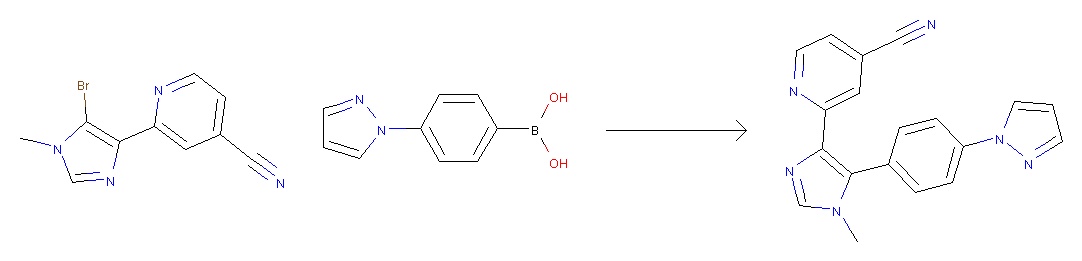

In [3]:
print(data['rxn_smiles'][5])
ReactionStringToImage(data['rxn_smiles'][5])

In [4]:
import multiprocessing
num_cores = multiprocessing.cpu_count()
#inputs = list(data.loc[data['dataset']=='train']['rxn_smiles'])
reaction_smiles = list(data.loc[data['dataset']=='train']['rxn_smiles']) # get a list of rxn labeled as train 

#def extract_one_template(reaction_smiles): 
def rxnTemplateFromOneSmarts(reaction_smiles): # bracket the templated reactants smiles 
    retro_canonical = process_an_example(reaction_smiles, super_general=True) # get the reaction template
    if retro_canonical is None:
        return None
    return '({})>>{}'.format(retro_canonical.split('>>')[0], retro_canonical.split('>>')[1])

In [5]:
!pip install joblib
from joblib import Parallel, delayed

In [6]:
#all_retro_canonical_uni = Parallel(n_jobs=num_cores, verbose=3)(delayed(extract_one_template)(i) for i in inputs)
all_retro_canonical_uni = Parallel(n_jobs=num_cores, verbose=3)(delayed(rxnTemplateFromOneSmarts)(smarts) for smarts in reaction_smiles)

templates = {}
for retro_canonical_uni in all_retro_canonical_uni:
    if retro_canonical_uni in templates:
        templates[retro_canonical_uni] += 1
    else:
        templates[retro_canonical_uni] = 1 

[Parallel(n_jobs=4)]: Done 296 tasks      | elapsed:    1.3s
[Parallel(n_jobs=4)]: Done 2024 tasks      | elapsed:    8.8s
[Parallel(n_jobs=4)]: Done 4904 tasks      | elapsed:   21.1s
[Parallel(n_jobs=4)]: Done 8936 tasks      | elapsed:   38.2s
[Parallel(n_jobs=4)]: Done 14120 tasks      | elapsed:  1.0min
[Parallel(n_jobs=4)]: Done 20456 tasks      | elapsed:  1.5min
[Parallel(n_jobs=4)]: Done 27944 tasks      | elapsed:  2.0min
[Parallel(n_jobs=4)]: Done 36584 tasks      | elapsed:  2.6min
[Parallel(n_jobs=4)]: Done 40008 out of 40008 | elapsed:  2.8min finished


In [7]:
print('NumOfTemplatesExtractedFrom50kRxns:', len(templates))
with open('../data/templates_general.json', 'w') as fid:
#with open('../data/templates_general.json', 'wb') as fid:
    json.dump(templates, fid, indent=4)

NumOfTemplatesExtractedFrom50kRxns: 1353


In [8]:
#for template, count in sorted(templates.iteritems(), key=lambda x: x[1], reverse=True)[:50]:
for template, count in sorted(templates.items(), key=lambda x: x[1], reverse=True)[:5]:
    print('{}     {}'.format(count, template))

2875     ([C;H0;+0:1]-[NH;+0:2])>>O-[C;H0;+0:1].[NH2;+0:2]
1797     ([OH;+0:1])>>C-[O;H0;+0:1]
1322     ([C;H0;+0:1]-[N;H0;+0:2])>>O-[C;H0;+0:1].[NH;+0:2]
1277     ([NH2;+0:1])>>O=[N+;H0:1]-[O-]
1213     ([NH;+0:1]-[c;H0;+0:2])>>Cl-[c;H0;+0:2].[NH2;+0:1]


In [9]:
sum([count == 1 for count in templates.values()])

571

# What test_one function do?

Look the figure down below:
The bond between 1 and 15 is likely to form in reaction
The bond between 6 and 7 is likely to form in reaction


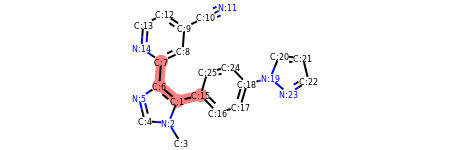

In [10]:
import rdkit.Chem as Chem
reaction_smiles = data.loc[data['dataset']=='train']['rxn_smiles'][5]
retro_canonical = rxnTemplateFromOneSmarts(reaction_smiles) 
product = Chem.MolFromSmiles(reaction_smiles.split('>')[-1])
pattern = Chem.MolFromSmarts(retro_canonical[1:].split(')>>')[0]) 
#matches = list(itertools.chain(*[x for x in product.GetSubstructMatches(pattern)]))
matches = [x for x in product.GetSubstructMatches(pattern)] 
print('Look the figure down below:')
for bondIndexes in matches:
    indexes = []
    for i, atom in enumerate(product.GetAtoms()): 
        if i in bondIndexes:
            indexes.append(atom.GetProp('molAtomMapNumber')) 
    print('The bond between {} and {} is likely to form in reaction'.format(indexes[0], indexes[1]))    
product

# Content of num_matches is a collection of mapping numbers indicate which bond is likely to form for each reaction

In [11]:
#import rdkit.Chem as Chem

def test_one(reaction_smiles):
    #retro_canonical = extract_one_template(reaction_smiles)
    retro_canonical = rxnTemplateFromOneSmarts(reaction_smiles)
    if retro_canonical is None:
        return -1
    product = Chem.MolFromSmiles(reaction_smiles.split('>')[-1])
    pattern = Chem.MolFromSmarts(retro_canonical[1:].split(')>>')[0])
    matches = set(frozenset(x) for x in product.GetSubstructMatches(pattern))
    return len(matches)

inputs = data.loc[data['dataset']=='train']['rxn_smiles']
num_matches = Parallel(n_jobs=num_cores, verbose=3)(delayed(test_one)(i) for i in inputs)

[Parallel(n_jobs=4)]: Done 296 tasks      | elapsed:    1.4s
[Parallel(n_jobs=4)]: Done 2024 tasks      | elapsed:    8.9s
[Parallel(n_jobs=4)]: Done 4904 tasks      | elapsed:   21.4s
[Parallel(n_jobs=4)]: Done 8936 tasks      | elapsed:   38.7s
[Parallel(n_jobs=4)]: Done 14120 tasks      | elapsed:  1.0min
[Parallel(n_jobs=4)]: Done 20456 tasks      | elapsed:  1.5min
[Parallel(n_jobs=4)]: Done 27944 tasks      | elapsed:  2.0min
[Parallel(n_jobs=4)]: Done 36584 tasks      | elapsed:  2.6min
[Parallel(n_jobs=4)]: Done 40008 out of 40008 | elapsed:  2.9min finished


# The figure tells us most product has only one bond that could be formed in reaction

Text(0,0.5,'Number of examples')

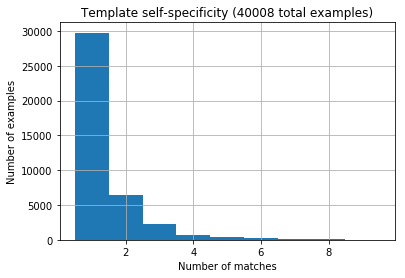

In [12]:
import matplotlib.pyplot as plt
%matplotlib inline
df = pd.DataFrame({'pop': num_matches})
plot = df['pop'].hist(bins=[x+0.5 for x in range(10)])
plot.set_title("Template self-specificity ({} total examples)".format(len(num_matches)))
plot.set_xlabel("Number of matches")
plot.set_ylabel("Number of examples")